In [1]:
# import all necessary packages
import ipywidgets as widgets
import IPython
from IPython.display import display
from IPython.display import HTML
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from IPython.display import Javascript, display
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
from IPython.display import Javascript

# Execute the next 7 cells
display(Javascript('IPython.notebook.execute_cells([1,2,3,4,5])'))

<IPython.core.display.Javascript object>

In [2]:
# Hide all of the code, so the UI is clean
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [3]:
# Get access to the Spotify library
CLIENT_ID = "aaddcd39d3b94eff8d638832094ad11c"
CLIENT_SECRET = "744795edffb748188abdf154a5078ea0"
username = '1255041959'
scope = 'user-library-read'
auth_manager = SpotifyClientCredentials(CLIENT_ID,CLIENT_SECRET)
sp = spotipy.Spotify(auth_manager=auth_manager)

token = util.prompt_for_user_token(username,scope,client_id=CLIENT_ID,
                                   client_secret=CLIENT_SECRET,
                                   redirect_uri='https://localhost.com/callback/')
userSP = spotipy.Spotify(auth=token)

In [4]:
class Song:
    def __init__(self, id, name, artist):
        self.id = id
        self.name = name
        self.artist = artist
        
    def __lt__(self, song):
        if self.name < song.name: return True
        else: return False
        
    def __le__(self, song):
        if self.name <= song.name: return True
        else: return False
        
    def __gt__(self, song):
        if self.name > song.name: return True
        else: return False
        
    def __ge__(self, song):
        if self.name >= song.name: return True
        else: return False
        
    def __str__(self):
        return self.name + " - " + self.artist

In [5]:
# Global variables
k = 3
track_id = []
track_name = []
artist_name = []
songs = []
ratings = {'rating': [],'numSongs':[],'numPlaylists':[]}

In [7]:
# Create widgets to display a user interface
title = widgets.HTML(value = "<h1 align='center'>Playlist Generator</h1>")
display(title)
errorMessage = widgets.Label(value="Something went wrong with the connection, hit the import button again.")
errorMessage.layout.visibility = 'hidden'
display(errorMessage)
leftLabel = widgets.Label(value="Choose songs below or import my songs:  ")
importSongs = widgets.Button(description="Import Songs")
hBox0 = widgets.HBox([leftLabel,importSongs])

search = widgets.Text(placeholder="Search for a song")
add = widgets.Button(description="Add")
hBox1 = widgets.HBox([search,add])

options = widgets.Select()
options.layout.width = "485px"
options.layout.height="200px"
rightLabel = widgets.Label(value="Selected Songs:")

selectedSongs = widgets.Select()
selectedSongs.layout.width= "485px"
selectedSongs.layout.height= "200px"
selectedSongs.options = songs

remove = widgets.Button(description="Remove")
progress = widgets.FloatProgress(description= 'importing', orientation = 'horizontal', min = 0, max=50)
progress.layout.visibility = 'hidden'
hBox4 = widgets.HBox([remove, progress])
vBox1 = widgets.VBox([hBox0,hBox1,options])
vBox2 = widgets.VBox([rightLabel,hBox4,selectedSongs])
hBox2 = widgets.HBox([vBox1, vBox2])
display(hBox2)

done = widgets.Button(description="Done")
loading = widgets.FloatProgress(description= 'loading', orientation = 'horizontal', min = 0, max = 50)
loading.layout.visibility = 'hidden'
chooseKLabel = widgets.Label(value="Number of playlists to generate: ")
chooseK = widgets.IntSlider(min = 2, max = 6, step = 1, value = k)
hBox3 = widgets.HBox([chooseKLabel,chooseK,done,loading])
display(hBox3)

# Create event handlers for the widgets
def importSongsHandler(obj):
    track_id.clear()
    track_name.clear()
    artist_name.clear()
    errorMessage.layout.visibility = 'hidden'
    try:
        progress.layout.visibility = 'visible'
        for i in range(0,7000,50):
            results = userSP.current_user_saved_tracks(limit=50,offset=i)
            for i, t in enumerate(results['items']):
                song = Song(t['track']['id'],t['track']['name'],t['track']['artists'][0]['name'])
                if song not in songs:
                    songs.append(song)
                progress.value = i
        songs.sort()
        selectedSongs.options = songs
        progress.layout.visibility = 'hidden'
    except:
        songs.clear()
        progress.layout.visibility = 'hidden'
        errorMessage.layout.visibility = 'visible'

def searchHandler(obj):
    tracks = sp.search(q=search.value, type="track", market='US', limit=50)
    choices = []
    for item in tracks['tracks']['items']:
        song = Song(item['id'], item['name'], item['artists'][0]['name'])
        choices.append(song)
    options.options = choices
    
def addButtonHandler(obj):
    if options.value != None:
        song = options.value
        if song not in songs:
            songs.append(song)
        songs.sort()
        selectedSongs.options = songs
    
def removeButtonHandler(obj):
    song = selectedSongs.value
    songs.remove(song)
    selectedSongs.options = songs
    
def slider(obj):
    global k
    k = chooseK.value
    
def doneButtonHandler(ev):
    loading.layout.visibility = 'visible'
    track_id.clear()
    track_name.clear()
    artist_name.clear()
    for item in songs:
        track_id.append(item.id)
        track_name.append(item.name)
        artist_name.append(item.artist)
    display(Javascript('IPython.notebook.execute_cells_below()'))
    
# Call the appropriate event handlers
importSongs.on_click(importSongsHandler)
search.on_submit(searchHandler)
add.on_click(addButtonHandler)
remove.on_click(removeButtonHandler)
chooseK.observe(slider)
done.on_click(doneButtonHandler)

<IPython.core.display.Javascript object>

HTML(value="<h1 align='center'>Playlist Generator</h1>")

Label(value='Something went wrong with the connection, hit the import button again.', layout=Layout(visibility…

In [8]:
# Create a dataframe that stores basic info: track ids, track names, and artist names
df_tracks = pd.DataFrame({'track_id':track_id,'track_name':track_name,'artist_name':artist_name})
df_tracks

,track_id,track_name,artist_name
0,6YQUuoMnRIMaOmouYoMfQr,"""99""",Barns Courtney
1,6z39NC4VSSweBHFg9kAoja,#1,Imagine Dragons
2,0w4m3Xp4svlIoyL94Zjlyd,&Run,Sir Sly
3,7uX3gufAoBVqKVoD3dBLLD,&burn (with Vince Staples),Billie Eilish
4,2MAVcVr2oylw2OZ3hojWYj,'74-'75,The Connells
...,...,...,...
6188,7jTJDt7RWCslzygXM1C3Ja,you mean the whole wide world to me,Christina Perri
6189,3XF5xLJHOQQRbWya6hBp7d,you should see me in a crown,Billie Eilish
6190,4lSMKPkbZOAYPw3zxJ2eAF,you!,LANY
6191,1IunpAQG8ifLoJ7qUeYdVh,your whatever,lovelytheband


In [9]:
# Use the track ids to get audio features and create a dataframe of those features
rows = []
batchsize = 100
for i in range(0,len(df_tracks['track_id']),batchsize):
    batch = df_tracks['track_id'][i:i+batchsize]
    feature_results = sp.audio_features(batch)
    for i, t in enumerate(feature_results):
        if t != None:
            rows.append(t)
            loading.value = i
df_audio_features = pd.DataFrame.from_dict(rows,orient='columns')
df_audio_features

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.552,0.8040,8,-4.299,1,0.0303,0.00598,0.000000,0.1110,0.714,95.980,audio_features,6YQUuoMnRIMaOmouYoMfQr,spotify:track:6YQUuoMnRIMaOmouYoMfQr,https://api.spotify.com/v1/tracks/6YQUuoMnRIMa...,https://api.spotify.com/v1/audio-analysis/6YQU...,199413,4
1,0.692,0.6950,1,-4.448,1,0.1090,0.08970,0.000000,0.1550,0.634,92.980,audio_features,6z39NC4VSSweBHFg9kAoja,spotify:track:6z39NC4VSSweBHFg9kAoja,https://api.spotify.com/v1/tracks/6z39NC4VSSwe...,https://api.spotify.com/v1/audio-analysis/6z39...,205041,4
2,0.764,0.6610,5,-8.276,1,0.0526,0.02030,0.000179,0.1790,0.479,92.018,audio_features,0w4m3Xp4svlIoyL94Zjlyd,spotify:track:0w4m3Xp4svlIoyL94Zjlyd,https://api.spotify.com/v1/tracks/0w4m3Xp4svlI...,https://api.spotify.com/v1/audio-analysis/0w4m...,226587,4
3,0.776,0.3790,9,-9.351,0,0.3310,0.21300,0.001750,0.0969,0.346,82.531,audio_features,7uX3gufAoBVqKVoD3dBLLD,spotify:track:7uX3gufAoBVqKVoD3dBLLD,https://api.spotify.com/v1/tracks/7uX3gufAoBVq...,https://api.spotify.com/v1/audio-analysis/7uX3...,179016,4
4,0.530,0.5900,11,-9.169,1,0.0250,0.18300,0.002270,0.0675,0.430,144.202,audio_features,2MAVcVr2oylw2OZ3hojWYj,spotify:track:2MAVcVr2oylw2OZ3hojWYj,https://api.spotify.com/v1/tracks/2MAVcVr2oylw...,https://api.spotify.com/v1/audio-analysis/2MAV...,278973,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6188,0.888,0.3270,0,-10.787,1,0.0435,0.96300,0.000012,0.1030,0.773,133.962,audio_features,7jTJDt7RWCslzygXM1C3Ja,spotify:track:7jTJDt7RWCslzygXM1C3Ja,https://api.spotify.com/v1/tracks/7jTJDt7RWCsl...,https://api.spotify.com/v1/audio-analysis/7jTJ...,108954,4
6189,0.678,0.5330,4,-10.485,1,0.1860,0.46200,0.219000,0.1390,0.323,150.455,audio_features,3XF5xLJHOQQRbWya6hBp7d,spotify:track:3XF5xLJHOQQRbWya6hBp7d,https://api.spotify.com/v1/tracks/3XF5xLJHOQQR...,https://api.spotify.com/v1/audio-analysis/3XF5...,180953,4
6190,0.500,0.6350,10,-7.530,1,0.0253,0.00648,0.005080,0.1260,0.276,94.000,audio_features,4lSMKPkbZOAYPw3zxJ2eAF,spotify:track:4lSMKPkbZOAYPw3zxJ2eAF,https://api.spotify.com/v1/tracks/4lSMKPkbZOAY...,https://api.spotify.com/v1/audio-analysis/4lSM...,274013,4
6191,0.478,0.5440,9,-10.747,1,0.0500,0.43700,0.000041,0.1870,0.299,112.082,audio_features,1IunpAQG8ifLoJ7qUeYdVh,spotify:track:1IunpAQG8ifLoJ7qUeYdVh,https://api.spotify.com/v1/tracks/1IunpAQG8ifL...,https://api.spotify.com/v1/audio-analysis/1Iun...,193929,4


In [10]:
# Clean the data by getting rid of some of the features that we don't want
columns_to_drop = ['analysis_url','track_href','type','uri','key','liveness','mode','duration_ms','time_signature']
df_audio_features.drop(columns_to_drop, axis=1,inplace=True)
df_audio_features.rename(columns={'id': 'track_id'}, inplace=True)
df_audio_features

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo,track_id
0,0.552,0.8040,-4.299,0.0303,0.00598,0.000000,0.714,95.980,6YQUuoMnRIMaOmouYoMfQr
1,0.692,0.6950,-4.448,0.1090,0.08970,0.000000,0.634,92.980,6z39NC4VSSweBHFg9kAoja
2,0.764,0.6610,-8.276,0.0526,0.02030,0.000179,0.479,92.018,0w4m3Xp4svlIoyL94Zjlyd
3,0.776,0.3790,-9.351,0.3310,0.21300,0.001750,0.346,82.531,7uX3gufAoBVqKVoD3dBLLD
4,0.530,0.5900,-9.169,0.0250,0.18300,0.002270,0.430,144.202,2MAVcVr2oylw2OZ3hojWYj
...,...,...,...,...,...,...,...,...,...
6188,0.888,0.3270,-10.787,0.0435,0.96300,0.000012,0.773,133.962,7jTJDt7RWCslzygXM1C3Ja
6189,0.678,0.5330,-10.485,0.1860,0.46200,0.219000,0.323,150.455,3XF5xLJHOQQRbWya6hBp7d
6190,0.500,0.6350,-7.530,0.0253,0.00648,0.005080,0.276,94.000,4lSMKPkbZOAYPw3zxJ2eAF
6191,0.478,0.5440,-10.747,0.0500,0.43700,0.000041,0.299,112.082,1IunpAQG8ifLoJ7qUeYdVh


In [11]:
# Combine the original dataframe of basic track info with the audio features dataframe
df = pd.merge(df_tracks,df_audio_features,on='track_id',how='inner')
df

,track_id,track_name,artist_name,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo
0,6YQUuoMnRIMaOmouYoMfQr,"""99""",Barns Courtney,0.552,0.8040,-4.299,0.0303,0.00598,0.000000,0.714,95.980
1,6z39NC4VSSweBHFg9kAoja,#1,Imagine Dragons,0.692,0.6950,-4.448,0.1090,0.08970,0.000000,0.634,92.980
2,0w4m3Xp4svlIoyL94Zjlyd,&Run,Sir Sly,0.764,0.6610,-8.276,0.0526,0.02030,0.000179,0.479,92.018
3,7uX3gufAoBVqKVoD3dBLLD,&burn (with Vince Staples),Billie Eilish,0.776,0.3790,-9.351,0.3310,0.21300,0.001750,0.346,82.531
4,2MAVcVr2oylw2OZ3hojWYj,'74-'75,The Connells,0.530,0.5900,-9.169,0.0250,0.18300,0.002270,0.430,144.202
...,...,...,...,...,...,...,...,...,...,...,...
6188,7jTJDt7RWCslzygXM1C3Ja,you mean the whole wide world to me,Christina Perri,0.888,0.3270,-10.787,0.0435,0.96300,0.000012,0.773,133.962
6189,3XF5xLJHOQQRbWya6hBp7d,you should see me in a crown,Billie Eilish,0.678,0.5330,-10.485,0.1860,0.46200,0.219000,0.323,150.455
6190,4lSMKPkbZOAYPw3zxJ2eAF,you!,LANY,0.500,0.6350,-7.530,0.0253,0.00648,0.005080,0.276,94.000
6191,1IunpAQG8ifLoJ7qUeYdVh,your whatever,lovelytheband,0.478,0.5440,-10.747,0.0500,0.43700,0.000041,0.299,112.082


In [12]:
# Display histograms of all of the audio features
%matplotlib inline
pd.options.display.max_columns = None
out1 = widgets.Output()
out2 = widgets.Output()
out3 = widgets.Output()
out4 = widgets.Output()
out5 = widgets.Output()
out6 = widgets.Output()
out7 = widgets.Output()
out8 = widgets.Output()

tab = widgets.Tab(children = [out1, out2, out3, out4, out5, out6, out7, out8])
tab.set_title(0, 'Acousticness')
tab.set_title(1, 'Danceability')
tab.set_title(2, 'Energy')
tab.set_title(3, 'Instrumentalness')
tab.set_title(4, 'Loudness')
tab.set_title(5, 'Speechiness')
tab.set_title(6, 'Tempo')
tab.set_title(7, 'Valence')
display(tab)

with out1:
    df['acousticness'].plot.hist(xlim = [0,1],figsize = [15,8])
    plt.show()
with out2:
    df['danceability'].plot.hist(xlim = [0,1],figsize = [15,8])
    plt.show()
with out3:
    df['energy'].plot.hist(xlim = [0,1],figsize = [15,8])
    plt.show()
with out4:
    df['instrumentalness'].plot.hist(xlim = [0,1],figsize = [15,8])
    plt.show()
with out5:
    df['loudness'].plot.hist(figsize = [15,8])
    plt.show()
with out6:
    df['speechiness'].plot.hist(xlim = [0,1],figsize = [15,8])
    plt.show()
with out7:
    df['tempo'].plot.hist(figsize = [15,8])
    plt.show()
with out8:
    df['valence'].plot.hist(xlim = [0,1],figsize = [15,8])
    plt.show()

In [13]:
# Copy the dataframe for future use
df_cluster = df.copy()

In [14]:
# Prepare the data for KMeans clustering by scaling the values to be between 0 and 1
X = df_cluster.iloc[:, [3,4,5,6,7,8,9,10]].values
scaler = MinMaxScaler()
scaled = scaler.fit_transform(X)

In [15]:
# Perform the KMeans clustering
kmeans = KMeans(n_clusters = k, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_kmeans = kmeans.fit_predict(scaled)

In [16]:
# Create a new dataframe that will store the cluster numbers
kmeans_df = pd.DataFrame(data=y_kmeans, dtype=int)
kmeans_df.columns = ['playlist']
kmeans_df

,playlist
0,4
1,4
2,2
3,2
4,2
...,...
6188,0
6189,0
6190,2
6191,0


In [17]:
# Add the cluster numbers to the tracks dataframe
df_cluster = pd.concat([df_cluster, kmeans_df], axis=1)
df_cluster

,track_id,track_name,artist_name,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo,playlist
0,6YQUuoMnRIMaOmouYoMfQr,"""99""",Barns Courtney,0.552,0.8040,-4.299,0.0303,0.00598,0.000000,0.714,95.980,4
1,6z39NC4VSSweBHFg9kAoja,#1,Imagine Dragons,0.692,0.6950,-4.448,0.1090,0.08970,0.000000,0.634,92.980,4
2,0w4m3Xp4svlIoyL94Zjlyd,&Run,Sir Sly,0.764,0.6610,-8.276,0.0526,0.02030,0.000179,0.479,92.018,2
3,7uX3gufAoBVqKVoD3dBLLD,&burn (with Vince Staples),Billie Eilish,0.776,0.3790,-9.351,0.3310,0.21300,0.001750,0.346,82.531,2
4,2MAVcVr2oylw2OZ3hojWYj,'74-'75,The Connells,0.530,0.5900,-9.169,0.0250,0.18300,0.002270,0.430,144.202,2
...,...,...,...,...,...,...,...,...,...,...,...,...
6188,7jTJDt7RWCslzygXM1C3Ja,you mean the whole wide world to me,Christina Perri,0.888,0.3270,-10.787,0.0435,0.96300,0.000012,0.773,133.962,0
6189,3XF5xLJHOQQRbWya6hBp7d,you should see me in a crown,Billie Eilish,0.678,0.5330,-10.485,0.1860,0.46200,0.219000,0.323,150.455,0
6190,4lSMKPkbZOAYPw3zxJ2eAF,you!,LANY,0.500,0.6350,-7.530,0.0253,0.00648,0.005080,0.276,94.000,2
6191,1IunpAQG8ifLoJ7qUeYdVh,your whatever,lovelytheband,0.478,0.5440,-10.747,0.0500,0.43700,0.000041,0.299,112.082,0


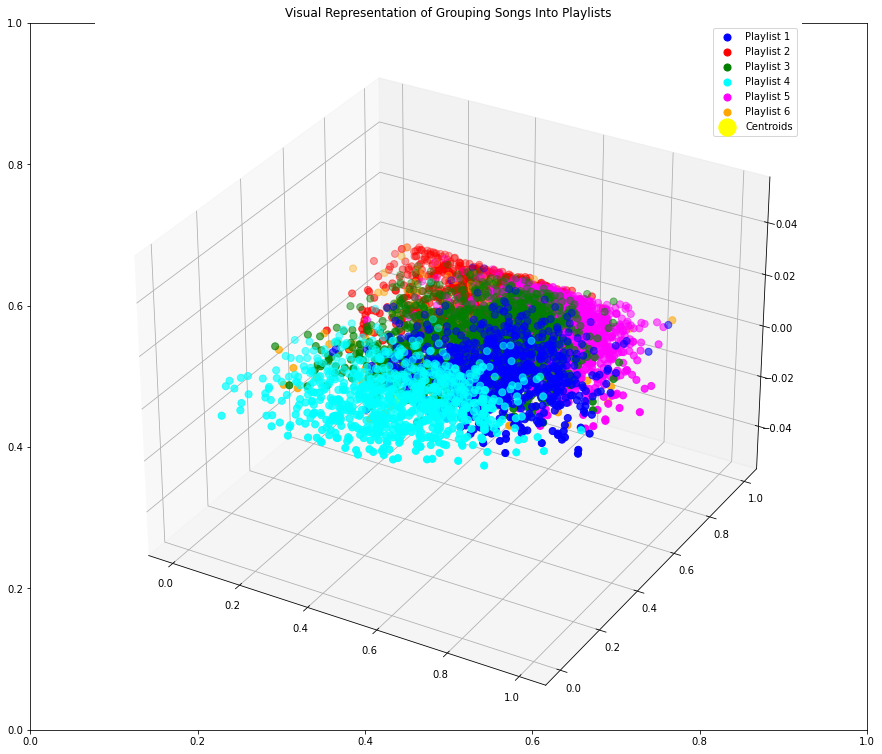

In [18]:
# Make a 3D plot to visualize the KMeans clustering process
fig, ax = plt.subplots(figsize=(15,13))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(scaled[y_kmeans == 0,0],scaled[y_kmeans == 0,1], s= 50, c= 'blue',label= 'Playlist 1')
plt.scatter(scaled[y_kmeans == 1,0], scaled[y_kmeans == 1,1], s= 50, c= 'red', label= 'Playlist 2')
if k > 2:
    plt.scatter(scaled[y_kmeans == 2,0], scaled[y_kmeans == 2,1], s= 50, c= 'green', label= 'Playlist 3')
if k > 3:
    plt.scatter(scaled[y_kmeans == 3,0], scaled[y_kmeans == 3,1], s= 50, c= 'cyan', label= 'Playlist 4')
if k > 4:
    plt.scatter(scaled[y_kmeans == 4,0], scaled[y_kmeans == 4,1], s= 50, c= 'magenta', label= 'Playlist 5')
if k > 5:
    plt.scatter(scaled[y_kmeans == 5,0], scaled[y_kmeans == 5,1], s= 50, c= 'orange', label= 'Playlist 6')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,1], s= 300, c= 'yellow', label= 'Centroids')
plt.title('Visual Representation of Grouping Songs Into Playlists')
plt.legend()
plt.show()

In [19]:
# Create a dataframe that stores the scaled audio features for all songs
df_scaled = pd.DataFrame(scaled)
df_scaled

,0,1,2,3,4,5,6,7
0,0.518777,0.803902,0.868969,0.018262,0.006008,0.000000,0.713128,0.283095
1,0.676186,0.693152,0.864218,0.200185,0.090149,0.000000,0.629976,0.265178
2,0.757140,0.658606,0.742147,0.069810,0.020400,0.000185,0.468870,0.259433
3,0.770632,0.372079,0.707867,0.713361,0.214069,0.001812,0.330631,0.202775
4,0.494041,0.586466,0.713671,0.006010,0.183918,0.002350,0.417940,0.571087
...,...,...,...,...,...,...,...,...
6188,0.896559,0.319244,0.662075,0.048775,0.967839,0.000012,0.774452,0.509932
6189,0.660445,0.528551,0.671705,0.378178,0.464321,0.226708,0.306725,0.608432
6190,0.460310,0.632189,0.765936,0.006704,0.006511,0.005259,0.257873,0.271270
6191,0.435575,0.539728,0.663350,0.063800,0.439195,0.000042,0.281779,0.379260


In [20]:
# Add the cluster numbers to the scaled audio features dataframe
df_radar = pd.concat([df_scaled, kmeans_df], axis=1)
df_radar

,0,1,2,3,4,5,6,7,playlist
0,0.518777,0.803902,0.868969,0.018262,0.006008,0.000000,0.713128,0.283095,4
1,0.676186,0.693152,0.864218,0.200185,0.090149,0.000000,0.629976,0.265178,4
2,0.757140,0.658606,0.742147,0.069810,0.020400,0.000185,0.468870,0.259433,2
3,0.770632,0.372079,0.707867,0.713361,0.214069,0.001812,0.330631,0.202775,2
4,0.494041,0.586466,0.713671,0.006010,0.183918,0.002350,0.417940,0.571087,2
...,...,...,...,...,...,...,...,...,...
6188,0.896559,0.319244,0.662075,0.048775,0.967839,0.000012,0.774452,0.509932,0
6189,0.660445,0.528551,0.671705,0.378178,0.464321,0.226708,0.306725,0.608432,0
6190,0.460310,0.632189,0.765936,0.006704,0.006511,0.005259,0.257873,0.271270,2
6191,0.435575,0.539728,0.663350,0.063800,0.439195,0.000042,0.281779,0.379260,0


In [21]:
# A function that returns a dataframe with average scaled audio features for a playlist
def avgDF(df):
    avg = pd.DataFrame(dict(
    r = [df[0].mean(), df[1].mean(), df[2].mean(), df[3].mean(), df[4].mean(), df[5].mean(), df[6].mean(), df[7].mean()],
    theta = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo']))
    return avg

In [22]:
# Create dataframes for each playlist that store the average scaled audio features for use in the radar charts
df_r1 = avgDF(df_radar.loc[df_radar['playlist'] ==0])
df_r2 = avgDF(df_radar.loc[df_radar['playlist'] ==1])
df_r3 = avgDF(df_radar.loc[df_radar['playlist'] ==2])
df_r4 = avgDF(df_radar.loc[df_radar['playlist'] ==3])
df_r5 = avgDF(df_radar.loc[df_radar['playlist'] ==4])
df_r6 = avgDF(df_radar.loc[df_radar['playlist'] ==5])
df_r1

,r,theta
0,0.599942,danceability
1,0.539072,energy
2,0.730868,loudness
3,0.069719,speechiness
4,0.503056,acousticness
5,0.017283,instrumentalness
6,0.596834,valence
7,0.415944,tempo


In [23]:
# Create lists to hold Song objects for each playlist for display purposes
p1, p2, p3, p4, p5, p6 = [], [], [], [], [], []

df_1 = df_cluster.loc[df_cluster['playlist'] == 0]
for i, row in df_1.iterrows():
    s = Song(row['track_id'], row['track_name'], row['artist_name'])
    p1.append(s)

df_2 = df_cluster.loc[df_cluster['playlist'] == 1]
for i, row in df_2.iterrows():
    s = Song(row['track_id'], row['track_name'], row['artist_name'])
    p2.append(s)

if k > 2: 
    df_3 = df_cluster.loc[df_cluster['playlist'] == 2]
    for i, row in df_3.iterrows():
        s = Song(row['track_id'], row['track_name'], row['artist_name'])
        p3.append(s)

if k > 3: 
    df_4 = df_cluster.loc[df_cluster['playlist'] == 3]
    for i, row in df_4.iterrows():
        s = Song(row['track_id'], row['track_name'], row['artist_name'])
        p4.append(s)

if k > 4: 
    df_5 = df_cluster.loc[df_cluster['playlist'] == 4]
    for i, row in df_5.iterrows():
        s = Song(row['track_id'], row['track_name'], row['artist_name'])
        p5.append(s)

if k > 5: 
    df_6 = df_cluster.loc[df_cluster['playlist'] == 5]
    for i, row in df_6.iterrows():
        s = Song(row['track_id'], row['track_name'], row['artist_name'])
        p6.append(s)

In [24]:
# Create tabs for each playlist that hold output objects
kids = []
c1 = widgets.Output()
kids.append(c1)
c2 = widgets.Output()
kids.append(c2)
if k > 2: 
    c3 = widgets.Output()
    kids.append(c3)
if k > 3: 
    c4 = widgets.Output()
    kids.append(c4)
if k > 4: 
    c5 = widgets.Output()
    kids.append(c5)
if k > 5: 
    c6 = widgets.Output()
    kids.append(c6)
tabs = widgets.Tab(children = kids)
tabs.set_title(0,'Playlist 1')
tabs.set_title(1,'Playlist 2')
if k > 2: tabs.set_title(2,'Playlist 3')
if k > 3: tabs.set_title(3,'Playlist 4')
if k > 4: tabs.set_title(4,'Playlist 5')
if k > 5: tabs.set_title(5,'Playlist 6')
display(tabs)

In [25]:
# Display a list of songs in the playlist with a radar chart of average audio features
def displayPlaylist(p, df):
    selection = widgets.Select(options = p)
    selection.layout.width='350px'
    selection.layout.height='400px'
    title = widgets.HTML(value = "<h2 align='center'>Songs</h2>")
    vBox = widgets.VBox([title, selection])
    radar = widgets.Output()
    innerTab = widgets.Tab(children = [radar])
    innerTab.set_title(0,'Audio Features')
    hbox = widgets.HBox([vBox,innerTab])
    display(hbox)
    with radar:
        fig = px.line_polar(df, r='r', theta='theta', line_close=True,width=450)
        fig.update_traces(fill='toself')
        fig.update_layout(polar = dict(radialaxis = dict(range=[0,1], showticklabels=False, ticks=''),
                angularaxis = dict(ticks='')))
        fig.show()

with c1:
    displayPlaylist(p1, df_r1)
with c2:
    displayPlaylist(p2, df_r2)
if k > 2:
    with c3:
        displayPlaylist(p3, df_r3)
if k > 3:
    with c4:
        displayPlaylist(p4, df_r4)
if k > 4:
    with c5:
        displayPlaylist(p5, df_r5)
if k > 5:
    with c6:
        displayPlaylist(p6, df_r6)

In [26]:
# Stop displaying the loading bar
loading.layout.visibility = 'hidden'

In [27]:
# Get feedback from the user
rateLabel = widgets.Label(value="Please rate the playlist generator on a scale from 1 to 10:")
rateUs = widgets.BoundedIntText(
    value=5,
    min=0,
    max=10,
    step=1,
    disabled=False
)
submit = widgets.Button(description="Submit")
ratingHbox = widgets.HBox([rateLabel,rateUs,submit])
display(ratingHbox)
goodbye = widgets.Label(value = "Thank you for your feedback")
     
def submitHandler(ev):
    ratings['rating'].append(rateUs.value)
    ratings['numSongs'].append(len(songs))
    ratings['numPlaylists'].append(k)
    display(goodbye)
    
submit.on_click(submitHandler)